# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:

**Note: if you are using the Udacity workspace, you *DO NOT* need to re-download these - they can be found in the `/data` folder as noted in the cell below.**

* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [1]:
import numpy as np
from glob import glob
import time
import pandas as pd
from tqdm import tqdm
import os
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline       
import matplotlib.gridspec as gridspec
import torch
import torchvision.models as models
from PIL import Image
import torch
from torchvision.transforms import ToTensor

import torchvision.transforms as transforms
from torchvision import transforms
from PIL import ImageFile

import os
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


In [3]:

def generate_csv(root_dir, index_bool=False):
    files = glob(root_dir+"/*/*")
    time0 = time.time()
    data_df = pd.DataFrame()
    for idx, file in enumerate(tqdm(files)):
        if idx%10000 == 0:
            print("[{}/{}]".format(idx, len(files)-1))

        face_id    = os.path.basename(file).split('.')[0]
        face_label = os.path.basename(os.path.dirname(file))
        data_df = data_df.append({'id': face_id, 'name': face_label}, ignore_index = True)
#     data_df = data_df.sort_values(by = ['name', 'id']).reset_index(drop = True)
    data_df['class'] = pd.factorize(data_df['name'])[0]
    return data_df

human_faces = generate_csv("/data/lfw")
#     data_df.to_csv(csv_name, index = index_bool)

  1%|          | 140/13233 [00:00<00:29, 450.15it/s]

[0/13232]


 76%|███████▌  | 10051/13233 [00:20<00:06, 489.63it/s]

[10000/13232]


100%|██████████| 13233/13233 [00:26<00:00, 495.64it/s]


In [4]:
dog_faces_df = generate_csv("/data/dog_images/*")


  1%|          | 98/8351 [00:00<00:16, 488.45it/s]

[0/8350]


100%|██████████| 8351/8351 [00:16<00:00, 505.37it/s]


In [5]:
human_faces_df=human_faces

In [6]:
human_freq= human_faces_df.groupby(["name"]).count()


In [7]:
def generate_df_dog(root_dir, index_bool=False):
    files = glob(root_dir+"/*/*/*")
    time0 = time.time()
    data_df = pd.DataFrame()
    for idx, file in enumerate(tqdm(files)):
        if idx % 10000== 0:
            print("[{}/{}]".format(idx, len(files)-1))
        face_id    = os.path.basename(file).split('.')[0]
        face_label = os.path.basename(os.path.dirname(file))
        data_type = file.split('/')[-3]
#         print(data_type)
        data_df = data_df.append({'id': face_id, 'name': face_label, "type":data_type}, ignore_index = True)
#     data_df = data_df.sort_values(by = ['name', 'id', "type"]).reset_index(drop = True)
#     data_df['class'] = pd.factorize(data_df['name'])[0]
    return data_df
dog_faces_df = generate_df_dog("/data/dog_images/")

dog_faces_df.head()

  2%|▏         | 131/8351 [00:00<00:18, 433.43it/s]

[0/8350]


100%|██████████| 8351/8351 [00:18<00:00, 460.92it/s]


,id,name,type
0,Mastiff_06833,103.Mastiff,train
1,Mastiff_06826,103.Mastiff,train
2,Mastiff_06871,103.Mastiff,train
3,Mastiff_06812,103.Mastiff,train
4,Mastiff_06831,103.Mastiff,train


In [8]:
dog_faces_df['class'] = pd.factorize(dog_faces_df['name'])[0]
dog_faces_df.tail()


,id,name,type,class
8346,Keeshond_06238,092.Keeshond,valid,131
8347,Lowchen_06674,100.Lowchen,valid,132
8348,Lowchen_06682,100.Lowchen,valid,132
8349,Lowchen_06708,100.Lowchen,valid,132
8350,Lowchen_06684,100.Lowchen,valid,132


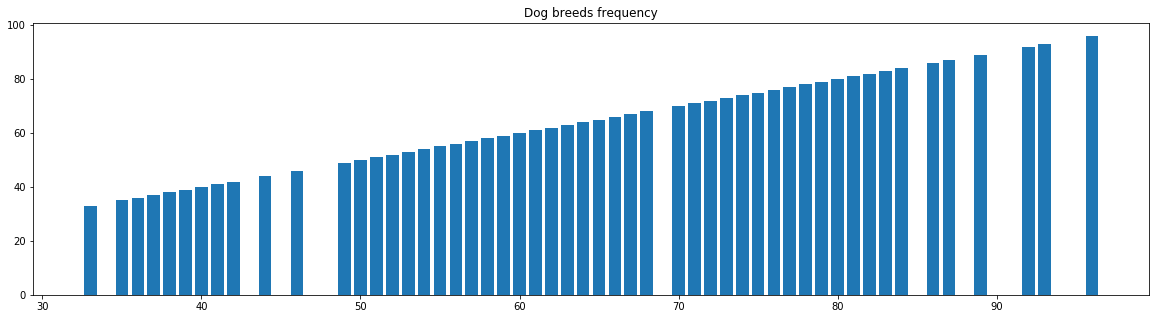

In [9]:

dog_freq= dog_faces_df.groupby(["name"]).count()
fig=plt.figure(figsize=(20,5))
plt.bar(dog_freq.id,dog_freq["class"])
plt.title("Dog breeds frequency")
plt.show()
plt.savefig('dog_breed_freq.png')


In [10]:
dog_freq.max()

id       96
type     96
class    96
dtype: int64

In [11]:
human_freq["class"].idxmax() 

'George_W_Bush'

In [12]:
dog_freq["class"].idxmax() 

'005.Alaskan_malamute'

In [13]:
human_freq.describe()

,id,class
count,5749.000000,5749.000000
mean,2.301792,2.301792
std,9.016410,9.016410
min,1.000000,1.000000
25%,1.000000,1.000000
50%,1.000000,1.000000
75%,2.000000,2.000000
max,530.000000,530.000000


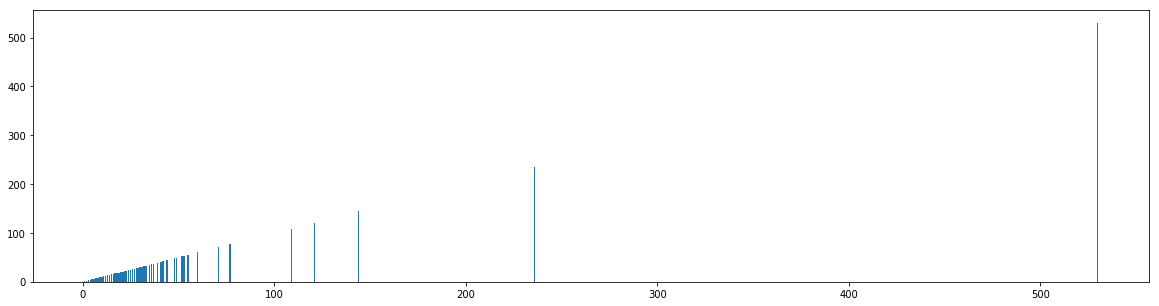

In [14]:
fig=plt.figure(figsize=(20,5))
plt.bar(human_freq.id,human_freq["class"])
# plt.title("frequency of LFW images")
plt.show()
plt.savefig('human_breed_freq.png')


# Trying augmentation

<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


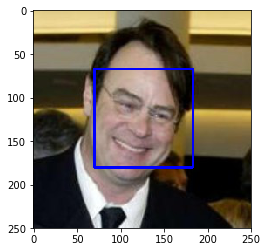

In [15]:
# extract pre-trained face detector

face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')
# cat_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalcatface.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [16]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

In [17]:
def draw_box_face(image):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    for (x,y,w,h) in faces:
        # add bounding box to color image
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,255),3)

    # convert BGR image to RGB for plotting
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return cv_rgb

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
(You can print out your results and/or write your percentages in this cell)

In [18]:

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]
count =0
for image in human_files_short:
    if face_detector(image)==True:
        count+=1
        
count_dog=0
for image in dog_files_short:
    if face_detector(image)==True:
        count_dog+=1

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
# detected


In [19]:
print("percent of detected human face in 100 human images is", count/len(human_files_short)*100,"%")
print("percent of detected human face in 100 dog images is", count_dog/len(dog_files_short)*100,"%")

percent of detected human face in 100 human images is 98.0 %
percent of detected human face in 100 dog images is 17.0 %


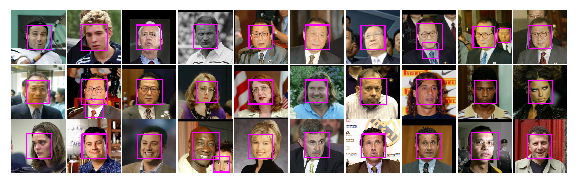

In [20]:
# plt.imshow(cv_rgb)
fig=plt.figure(figsize=(10,3))
columns = 10
rows = 3
gs1 = gridspec.GridSpec(rows, columns) 
gs1.update(wspace=0.00, hspace=0.00) 
for i in range(1, columns*rows +1):
    img = cv2.imread(human_files_short[i])
    img=draw_box_face(img)
#     ax1=fig.add_subplot(rows, columns, i)
    ax1 = plt.subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis('off')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
plt.subplots_adjust(wspace=0.01, hspace=0.01)
plt.show()

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [21]:
### (Optional) 
### TODO: Test performance of anotherface detection algorithm.

def resize(images):
    width = int(224)
    height = int(224)
    dim = (width, height)
    '''images contains original dimension image array'''
    resized_images=[]
    for i in range(0,images.shape[0]):
           image=cv2.imread(images[i])
           resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
           resized_images.append(resized)
    return resized_images

dog_faces_resized= resize(dog_files[:100])

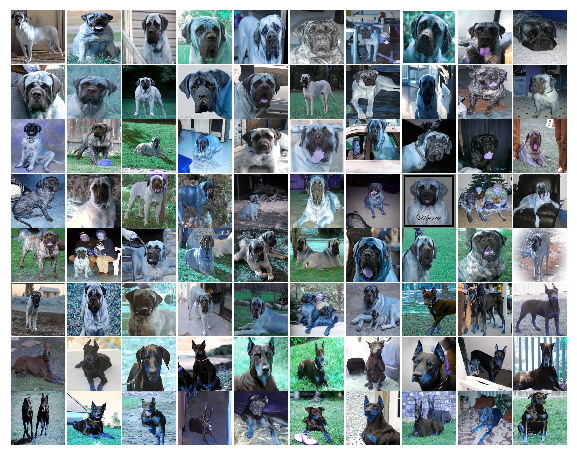

In [22]:

fig=plt.figure(figsize=(10,8))
columns = 10
rows = 8
gs1 = gridspec.GridSpec(rows, columns) 
gs1.update(wspace=0.00, hspace=0.00) 
for i in range(1, columns*rows +1):
#     img = cv2.imread(dog_faces_resized[i])
    ax1 = plt.subplot(rows, columns, i)
    plt.imshow(dog_faces_resized[i])
    plt.axis('off')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
plt.subplots_adjust(wspace=0.01, hspace=0.01)
plt.show()

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [23]:
use_cuda = torch.cuda.is_available()
use_cuda

True

In [24]:

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [01:44<00:00, 5307716.37it/s] 


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

## Transform and Detect dogs using VGG16

In [25]:

#with normalization

def transformer(img):
    transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])
    
    image_tensor = transform(img)
    return image_tensor.unsqueeze(0)
#without normalization
def transformer_un(img):
    transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])
    
    image_tensor = transform(img)
    return image_tensor.unsqueeze(0)

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
#     VGG16.eval()
    img_t = transformer(Image.open(img_path))
    img_t=img_t.to("cuda")
    out = VGG16(img_t).cpu()
     
    index = out.data.numpy().argmax()
    
    return index # predicted class index
print(VGG16_predict(human_files_short[1]))
print(VGG16_predict(dog_files_short[1]))

456
243


### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [26]:
### returns "True" if a dog is detected in the image stored at img_path
#with normalization
def dog_detector(img_path):
    ## TODO: Complete the function.

#     VGG16.eval
#     img = Image.open(img_path)
    img_t = transformer(Image.open(img_path))
    img_t=img_t.to("cuda")
    out = VGG16(img_t).cpu()
     
    index = out.data.numpy().argmax()
#     print(index)
    if 151 <= index <= 268:
        return True

    return False # true/false
#without normalization
def dog_detector_un(img_path):

    img_t = transformer_un(Image.open(img_path))
    img_t=img_t.to("cuda")
    out = VGG16(img_t).cpu()
     
    index = out.data.numpy().argmax()
#     print(index)
    if 151 <= index <= 268:
        return True

    return False # true/false

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

In [27]:
count=0
for image in human_files_short:
    if dog_detector(image)==True:
        count+=1
print(count)

1


In [28]:
count =0
for image in human_files_short:
    if dog_detector(image)==True:
        count+=1
print(count/len(human_files_short)* 100,"%", "of human images detected as dog" )
count =0

#using normalized transform data loader
for image in dog_files_short:
    if dog_detector(image)==True:
        count+=1
print(count/len(dog_files_short)* 100,"%", "of dog images detected as dog in normalized images")
#using unnormalized transform data loader

count =0
for image in dog_files_short:
    if dog_detector_un(image)==True:
        count+=1
print(count/len(dog_files_short)* 100,"of dog images detected as dog in unnormalized images")

1.0 % of human images detected as dog
100.0 % of dog images detected as dog in normalized images
94.0 of dog images detected as dog in unnormalized images


__Answer:__ 


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

## Detect dogs using RESNET

In [28]:
### (Optional) 
resnet50 = models.resnet50(pretrained=True)
resnet50
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 72720637.40it/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [29]:
def resnetdog_detector(img_path):

    if use_cuda:
        resnet50.cuda()
    img_t = transformer(Image.open(img_path))
    img_t=img_t.to("cuda")
    out = resnet50(img_t).cpu()
    index = out.data.numpy().argmax()

    if 151 <= index <= 268:
        return True

    return False # true/false


In [30]:
count =0
for image in human_files_short:
    if resnetdog_detector(image)==True:
        count+=1
print(count/len(human_files_short))
count =0
for image in dog_files_short:
    if resnetdog_detector(image)==True:
        count+=1
print(count/len(dog_files_short)* 100," %")

0.0
0.0  %


In [31]:
alex = models.alexnet(pretrained=True)


Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.torch/models/alexnet-owt-4df8aa71.pth
100%|██████████| 244418560/244418560 [00:02<00:00, 104059516.87it/s]


## Detect dogs using Alexnet

In [32]:
def alexdog_detector(img_path):

    if use_cuda:
        alex.cuda()
    img_t = transformer(Image.open(img_path))
    img_t=img_t.to("cuda")
    out = alex(img_t).cpu()
    index = out.data.numpy().argmax()
    if 151 <= index <= 268:
        return True

    return False # true/false


In [33]:
count =0
for image in human_files_short:
    if alexdog_detector(image)==True:
        count+=1
print(count/len(human_files_short)* 100,"%", "of huamn images detected as dog")
count=0
for image in dog_files_short:
    if alexdog_detector(image)==True:
        count+=1
print(count/len(dog_files_short)* 100,"%", "of dog images detected as dog")

0.0 % of huamn images detected as dog
99.0 % of dog images detected as dog


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [34]:


ImageFile.LOAD_TRUNCATED_IMAGES = True

In [35]:

# import torchsample as ts
import torch
data_dir= "/data/dog_images/"
class_transforms = []

train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                           transforms.RandomHorizontalFlip(),
                                           transforms.Resize(224),
                                           transforms.CenterCrop(224),
                                           transforms.ColorJitter(
                                                                    brightness=0.1*torch.randn(1),
                                                                    contrast=0.1*torch.randn(1),
                                                                    saturation=0.1*torch.randn(1),
                                                                    hue=0.1*torch.randn(1)),
                                           transforms.ToTensor(),
                                           transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

train_datasets = datasets.ImageFolder( os.path.join(data_dir,"test") , transform=train_transforms)
trainloader = torch.utils.data.DataLoader(train_datasets, batch_size=100, shuffle=True)
# dog_classes = trainloader.classes
data, target = iter(trainloader).next()
print(target)

tensor([   6,    4,   46,   94,    9,   38,  120,   30,   30,   82,
          91,   82,  107,   98,   13,  108,  130,   43,   68,   63,
          72,  101,   87,   93,   31,   55,   23,  117,   17,   78,
          24,  126,   76,   62,   12,   41,   26,   64,   27,   24,
          43,    8,    2,   38,   45,   44,   68,   44,   82,    7,
           1,   50,   15,   59,  106,    9,   90,   18,  122,   26,
          50,   86,   44,  110,   68,   53,   22,  122,   26,  110,
         105,   68,   49,   95,   35,   58,    7,   80,   93,   11,
          52,   87,   71,   76,  111,   58,   57,   40,   94,    2,
          64,    3,   46,   78,  102,   68,   88,   73,   86,   13])


In [4]:
data_dir= "/data/dog_images/"
data_transformers={
                    "train":transforms.Compose([
#                         transforms.RandomRotation(10),
                        transforms.RandomHorizontalFlip(),
                        transforms.RandomResizedCrop(224),
#                         transforms.Resize(224),
                       transforms.ColorJitter(
                                                brightness=10*torch.randn(1),
                                                contrast=0.1*torch.randn(1),
#                                                 saturation=0.1*torch.randn(1),
#                                                 hue=0.1*torch.randn(1)
                                                   ),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]),
                    "test":transforms.Compose([
#                         transforms.RandomRotation(10),
#                         transforms.RandomHorizontalFlip(),
                        transforms.CenterCrop(224),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]),
                    "valid":transforms.Compose([
                        transforms.CenterCrop(224),
#                         transforms.Resize(224),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
                        }

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
def dataloader(type):
    train_datasets = datasets.ImageFolder( os.path.join(data_dir,type) , transform=data_transformers[type])
    trainloader = torch.utils.data.DataLoader(train_datasets, batch_size=32, shuffle=False)
    return trainloader
x=dataloader("test")
train_data, train_label = iter(x).next()
# train_data, train_label= dataloader("train")
label_idx=train_label.numpy().squeeze()
dog_classes =dataloader("train").dataset.classes


In [5]:
loaders_scratch={}
for loader_type in ['train', 'valid', 'test']:
    loader = dataloader(loader_type)
    loaders_scratch[loader_type]=loader

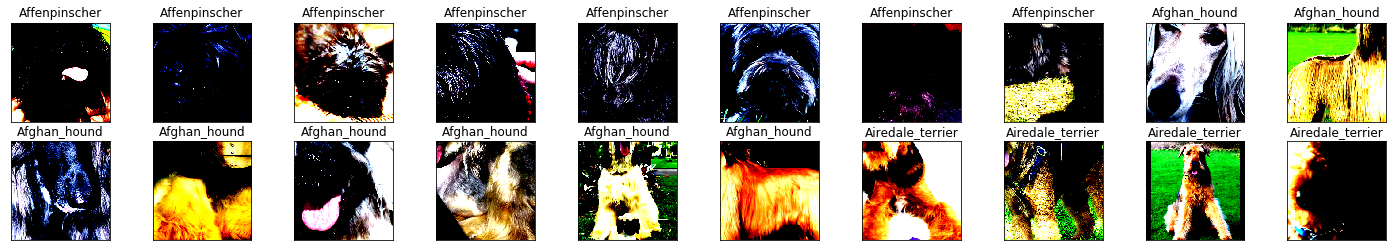

In [31]:

def to_tensor(tensor):
    img = tensor.numpy().squeeze()
    image = img.transpose(1,2,0)
    return image.clip(0, 1)
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(to_tensor(train_data[idx]))
    ax.set_title(dog_classes[label_idx[idx]].split(".")[1])
plt.show()

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?



**Answer**:



The approach I have used to apply the following transformation and augmentation techniques to the train data loaders 

- Random Horizontal Flip

- Random Resized Crop

- Color Jitter

- Normalization

I have resized and normalized the test and validation data without any colour jitter transformation and augmentation technique


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

# Version 1

Net(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.5)
  (fc1): Linear(in_features=3136, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=133, bias=True)
)
Train Epoch: 10 [0/6680 (0%)]	Loss: 4.890350
Train Epoch: 10 [640/6680 (10%)]	Loss: 4.890446
Train Epoch: 10 [1280/6680 (19%)]	Loss: 4.890858
Train Epoch: 10 [1920/6680 (29%)]	Loss: 4.890357
Train Epoch: 10 [2560/6680 (38%)]	Loss: 4.890362
Train Epoch: 10 [3200/6680 (48%)]	Loss: 4.890350
Train Epoch: 10 [3840/6680 (57%)]	Loss: 4.892519
Train Epoch: 10 [4480/6680 (67%)]	Loss: 4.890837
Train Epoch: 10 [5120/6680 (77%)]	Loss: 4.890675
Train Epoch: 10 [5760/6680 (86%)]	Loss: 4.890893
Train Epoch: 10 [6400/6680 (96%)]	Loss: 4.890418
Epoch: 10 	Training Loss: 0.000732 	Validation Loss: -55.358807 	Accuracy: 8/835 (0.96%)

Train Epoch: 11 [0/6680 (0%)]	Loss: 4.891499
Train Epoch: 11 [640/6680 (10%)]	Loss: 4.891387
Train Epoch: 11 [1280/6680 (19%)]	Loss: 4.891282
Train Epoch: 11 [1920/6680 (29%)]	Loss: 4.898806
Train Epoch: 11 [2560/6680 (38%)]	Loss: 4.890590
Train Epoch: 11 [3200/6680 (48%)]	Loss: 4.879338
Train Epoch: 11 [3840/6680 (57%)]	Loss: 4.890395
Train Epoch: 11 [4480/6680 (67%)]	Loss: 4.890350
Train Epoch: 11 [5120/6680 (77%)]	Loss: 4.890350
Train Epoch: 11 [5760/6680 (86%)]	Loss: 4.890350
Train Epoch: 11 [6400/6680 (96%)]	Loss: 4.890398
Epoch: 11 	Training Loss: 0.000732 	Validation Loss: -52.383675 	Accuracy: 8/835 (0.96%)

Train Epoch: 12 [0/6680 (0%)]	Loss: 4.890350
Train Epoch: 12 [640/6680 (10%)]	Loss: 4.890350
Train Epoch: 12 [1280/6680 (19%)]	Loss: 4.890876
Train Epoch: 12 [1920/6680 (29%)]	Loss: 4.890497
Train Epoch: 12 [2560/6680 (38%)]	Loss: 4.890861
Train Epoch: 12 [3200/6680 (48%)]	Loss: 4.882218
Train Epoch: 12 [3840/6680 (57%)]	Loss: 4.897716
Train Epoch: 12 [4480/6680 (67%)]	Loss: 4.890525
Train Epoch: 12 [5120/6680 (77%)]	Loss: 4.891222


Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=25088, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=133, bias=True)
  (dropout): Dropout(p=0.3)
)
Train Epoch: 7 [0/6680 (0%)]	Loss: 5.012314
Train Epoch: 7 [640/6680 (10%)]	Loss: 4.834976
Train Epoch: 7 [1280/6680 (19%)]	Loss: 4.873857
Train Epoch: 7 [1920/6680 (29%)]	Loss: 4.915187
Train Epoch: 7 [2560/6680 (38%)]	Loss: 5.096109
Train Epoch: 7 [3200/6680 (48%)]	Loss: 4.904694
Train Epoch: 7 [3840/6680 (57%)]	Loss: 4.916771
Train Epoch: 7 [4480/6680 (67%)]	Loss: 4.934455
Train Epoch: 7 [5120/6680 (77%)]	Loss: 4.796196
Train Epoch: 7 [5760/6680 (86%)]	Loss: 4.834973
Train Epoch: 7 [6400/6680 (96%)]	Loss: 4.904770
Epoch: 7 	Training Loss: 0.000733 	Validation Loss: -190.679718 	Accuracy: 7/835 (0.84%)


In [68]:
from torch.nn.init import xavier_uniform as xavier
# torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0,...)
# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
#         ((W−F+2P)/S)+ 1.
        #(224-3+2)/1+1
        self.conv1=nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2),padding=1, bias=False) #torch.Size([32, 64, 112, 112])
#         (112-3+2)/2+1
        self.conv2=nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2),padding=1, bias=False) #torch.Size([32, 32, 56, 56])

        self.conv3=nn.Conv2d(64, 32, kernel_size=(3, 3), stride=(2, 2),padding=1, bias=False) #torch.Size([64, 32, 28, 28])
#         self.dropout = nn.Dropout2d(0.25)

        self.conv4=nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2),padding=1, bias=False) #torch.Size([64, 32, 28, 28]
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(64*7*7,64)
        self.fc2 = nn.Linear(64, 133)        
    def forward(self, x):
        ## Define forward behavior
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.dropout(x)
        x = self.conv4(x)
        
        x= self.pool(x)
        x = x.view(-1,64*7*7)
#         print(x.shape)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
#         print(x.shape)

#         x = self.dropout(x)
#         output = F.log_softmax(x, dim=1)
#         print(output.shape)

#         output = F.log_softmax(x, dim=1)
        return x

#-#-# You so NOT have to modify the code below this line. #-#-#
use_cuda = torch.cuda.is_available()

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()
# model_scratch(train_data.cuda())
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight)
#         m.bias.fill_(0.01)
model_scratch.apply(init_weights)

Net(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.5)
  (fc1): Linear(in_features=3136, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=133, bias=True)
)

# Version 2

In [42]:

# torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0,...)
# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(3, 3),padding=1, bias=False) #torch.Size([32, 64, 112, 112])

        # takes 224/2 = 112/2 (max pooling)----56
        self.conv2=nn.Conv2d(32, 64, kernel_size=(3, 3),padding=1, bias=False) #torch.Size([32, 64, 56, 56])

        # takes 112/2= 56
        self.conv3=nn.Conv2d(64, 128, kernel_size=(3, 3),padding=1, bias=False) #torch.Size([32, 128, 28, 28])

        # takes 56/2= 28
        self.conv4=nn.Conv2d(128, 256, kernel_size=(3, 3),padding=1, bias=False) #torch.Size([32, 256, 14, 14])

        # takes 28/2= 14
        self.conv5=nn.Conv2d(256, 512, kernel_size=(3, 3),padding=1, bias=False) #torch.Size([32, 512, 7, 7])
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(512*7*7, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 133)
        
        self.dropout = nn.Dropout(0.30)
        
        
    def forward(self, x):
        
        x = F.relu(self.conv1(x))
#         print(x.shape)

        x = self.pool(x)

        x = F.relu(self.conv2(x))
        x = self.pool(x)
#         print(x.shape)

        x = F.relu(self.conv3(x))
        x = self.pool(x)
#         print(x.shape)

        x = F.relu(self.conv4(x))
        x = self.pool(x)
#         print(x.shape)
 
        x = F.relu(self.conv5(x))
        x = self.pool(x)
#         print(x.shape)

        x = x.view(-1, 512*7*7)
        
        x = self.dropout(x)
        x = F.relu(self.fc1(x))

        x = self.dropout(x)
        x = F.relu(self.fc2(x))

        x = self.dropout(x)
        x = self.fc3(x)
#         print(x.shape)

        output = F.log_softmax(x, dim=1)
        return output
    

#-#-# You so NOT have to modify the code below this line. #-#-#
use_cuda = torch.cuda.is_available()

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()


__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer 4__:

This 

## Version 3

In [ ]:
# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        
        # takes 224x224x3
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        
        # takes 112/2= 56
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        
        # takes 56/2= 28
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        
        # takes 28/2= 14
        self.conv5 = nn.Conv2d(256, 512, 3, padding=1)
        
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(512*7*7, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 133)
        
        self.dropout = nn.Dropout(0.30)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)

        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = F.relu(self.conv3(x))
        x = self.pool(x)

        x = F.relu(self.conv4(x))
        x = self.pool(x)
        
        x = F.relu(self.conv5(x))
        x = self.pool(x)

        x = x.view(-1, 512*7*7)
        
        x = self.dropout(x)
        x = F.relu(self.fc1(x))

        x = self.dropout(x)
        x = F.relu(self.fc2(x))

        x = self.dropout(x)
        x = self.fc3(x)
        
        return x
#-#-# You so NOT have to modify the code below this line. #-#-#
use_cuda = torch.cuda.is_available()

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

## Version 4
This is motivated from Alexnet wit slight motivation.  I have taken the code and modified a bit the code [here!][https://github.com/dansuh17/alexnet-pytorch/blob/master/model.py]

In [8]:
class Net(nn.Module):
    def __init__(self, num_classes=1000):

        super().__init__()
        #         ((W−F+2P)/S)+ 1.
        #(224-3+2)/1+1
        # input size should be : (b x 3 x 224 x 227)
        # The image in the original paper states that width and height are 224 pixels, but
        # the dimensions after first convolution layer do not lead to 55 x 55.
        (224-11)/4+1
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4),  # (b x 96 x 55 x 55)
            nn.ReLU(),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),  # section 3.3
            nn.MaxPool2d(kernel_size=3, stride=2),  # (b x 96 x 27 x 27)
            nn.Conv2d(96, 256, 5, padding=2),  # (b x 256 x 27 x 27)
            nn.ReLU(),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),  # (b x 256 x 13 x 13)
            nn.Conv2d(256, 384, 3, padding=1),  # (b x 384 x 13 x 13)
            nn.ReLU(),
            nn.Conv2d(384, 384, 3, padding=1),  # (b x 384 x 13 x 13)
            nn.ReLU(),
            nn.Conv2d(384, 256, 3, padding=1),  # (b x 256 x 13 x 13)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),  # (b x 256 x 6 x 6)
        )
        # classifier is just a name for linear layers
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(in_features=(256 * 5 * 5), out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Linear(in_features=4096, out_features=133),
        )
        self.init_bias()  # initialize bias

    def init_bias(self):
        for layer in self.net:
            if isinstance(layer, nn.Conv2d):
                nn.init.normal_(layer.weight, mean=0, std=0.01)
                nn.init.constant_(layer.bias, 0)
        # original paper = 1 for Conv2d layers 2nd, 4th, and 5th conv layers
        nn.init.constant_(self.net[4].bias, 1)
        nn.init.constant_(self.net[10].bias, 1)
        nn.init.constant_(self.net[12].bias, 1)

    def forward(self, x):
        """
        Pass the input through the net.
        Args:
            x (Tensor): input tensor
        Returns:
            output (Tensor): output tensor
        """
        x = self.net(x)
        print(x.shape)
        x = x.view(-1, 256 * 5 * 5)  # reduce the dimensions for linear layer input
        return self.classifier(x)
use_cuda = torch.cuda.is_available()

# instantiate the CNN
model_scratch1 = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch1.cuda()
model_scratch1

Net(
  (net): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU()
    (2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU()
    (6): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace)
    (1): Linear(in_features=6400, out_features=4096, bias=True)
    (2): ReLU()
    (

In [9]:
torch.cuda.empty_cache()

In [10]:
# testing on just a loaded training data
model_scratch1(train_data.cuda())


torch.Size([32, 256, 5, 5])


tensor([[ 0.1828,  0.0962,  0.0756,  ...,  0.3895,  0.0028, -0.2201],
        [ 0.0473,  0.1031, -0.0799,  ...,  0.3094,  0.1458, -0.1739],
        [ 0.2377,  0.0376,  0.1384,  ..., -0.1565, -0.3894, -0.1478],
        ...,
        [ 0.1928,  0.0838,  0.0364,  ..., -0.0409, -0.3243, -0.1845],
        [ 0.1901, -0.1532,  0.1756,  ...,  0.4371, -0.4130, -0.0632],
        [-0.0708,  0.1086,  0.0858,  ..., -0.1626, -0.2657,  0.0799]], device='cuda:0')

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [11]:
gamma=0.5
### TODO: select loss function
criterion_scratch =   nn.CrossEntropyLoss()
# optimizer_scratch = optim.Adam(model_scratch.classifier[6].parameters(), lr=0.001)
optimizer_scratch = optim.Adam(model_scratch1.parameters(), lr=0.001)

# optimizer =optim.SGD(model_scratch.parameters(), lr=0.001, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
### TODO: select optimizer
# optimizer_scratch =optim.Adam(model_scratch.parameters(), lr=0.005)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [6]:
# model_scratch1.load_state_dict(torch.load('model_scratch_vgg.pt'))
log_interval= 20
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        correct = 0
        total =0

        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
                
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            if batch_idx % log_interval == 0:
                    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        epoch, batch_idx * len(data), len(loaders['train'].dataset),
                        100. * batch_idx / len(loaders['train']), loss.item()))

                ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)

            valid_loss +=valid_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            # compare predictions to true label
            correct += pred.eq(target.view_as(pred)).sum().item()
#             correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            total += data.size(0)        # compare predictions to true label

#             correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
#             total += data.size(0)
#             correct += pred.eq(target.view_as(pred)).sum().item()
          
            
        train_loss = train_loss/len(loaders['train'].sampler)
        valid_loss = valid_loss/len(loaders['valid'].sampler) 
        Accuracy =100. * correct / total
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tAccuracy: {}/{} ({:.2f}%)\n'.format(
            epoch, 
            train_loss,
            valid_loss,correct, total,
            Accuracy
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            print('Valid loss decreased ({:.2f} --> {:.2f}).  Saving model ...'.format(
                valid_loss_min,
                valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss            
    # return trained model
    return model

# train the model


#I was not sure of number of epochs to train in total.
started small and did a total of 250 epochs to achieve >10% accuracy.
MY workspace keeps shutting down. So i train in small small epochs of 20 and would load the saved model into workspace again and resume the training.


In [7]:
# i comment out this line to load the model and continue training. 
#I was not sure of number of epochs to train in total.
#started small and did a total of 150 epochs to achieve >10% accuracy

# model_cratch1.load_state_dict(torch.load('model_scratch.pt'))
model_scratch1 = train(10, loaders_scratch, model_scratch1, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy


NameError: name 'model_scratch1' is not defined

In [ ]:
sadly, i mistakenly ran the above cell just before submitting and it cleared the output and it took a lot of time to train.
i have test in the next cell with the saved model from the above

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [12]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    


In [15]:
model_scratch1.load_state_dict(torch.load('model_scratch.pt'))
# model_scratch1


test(loaders_scratch, model_scratch1, criterion_scratch, use_cuda)

Test Loss: 3.680493


Test Accuracy: 20% (170/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [23]:
## TODO: Specify data loaders
loaders_transfer={}
for loader_type in ['train', 'valid', 'test']:
    loader = dataloader(loader_type)
    loaders_transfer[loader_type]=loader

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [34]:
import torchvision
model_transfer = models.vgg19(pretrained=True)

# check if CUDA is available
# use_cuda = torch.cuda.is_available()

## TODO: Specify model architecture 
# model_transfer = torchvision.models.vgg19(pretrained=True)
#     # Replace the last fully-connected layer
#     # Parameters of newly constructed modules have requires_grad=True by default


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.torch/models/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:26<00:00, 21937396.58it/s]


In [35]:
# model.fc = nn.Linear(512, 8) # assuming that the fc7 layer has 512 neurons, otherwise change it 
# model.cuda()
# model.fc = nn.Linear(512, 8) # assuming that the fc7 layer has 512 neurons, otherwise change it 
# model.cuda()
for param in model_transfer.parameters():
    param.requires_grad = False
    
model_transfer.classifier[6]=nn.Linear(4096, 133)


use_cuda = torch.cuda.is_available()

if use_cuda:
# model_transfer
# if use_cuda:
    model_transfer = model_transfer.cuda()

In [24]:
model_transfer

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [58]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.Adam(model_transfer.classifier[6].parameters(), lr = 0.001)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [ ]:
# train the model
n_epochs=50
model_transfer =  train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer_vgg.pt')

# load the model that got the best validation accuracy (uncomment the line below)
# model_transfer.load_state_dict(torch.load('model_transfer.pt')

Train Epoch: 1 [0/6680 (0%)]	Loss: 1.189634
Train Epoch: 1 [640/6680 (10%)]	Loss: 2.359335
Train Epoch: 1 [1280/6680 (19%)]	Loss: 1.092174
Train Epoch: 1 [1920/6680 (29%)]	Loss: 1.765017
Train Epoch: 1 [2560/6680 (38%)]	Loss: 2.300964
Train Epoch: 1 [3200/6680 (48%)]	Loss: 1.930445
Train Epoch: 1 [3840/6680 (57%)]	Loss: 3.631855
Train Epoch: 1 [4480/6680 (67%)]	Loss: 5.367345
Train Epoch: 1 [5120/6680 (77%)]	Loss: 3.805964
Train Epoch: 1 [5760/6680 (86%)]	Loss: 2.238711
Train Epoch: 1 [6400/6680 (96%)]	Loss: 1.716796
Epoch: 1 	Training Loss: 0.000318 	Validation Loss: -7658.166504 	Accuracy: 533/835 (63.83%)

Valid loss decreased (inf --> -7658.17).  Saving model ...
Train Epoch: 2 [0/6680 (0%)]	Loss: 0.549526
Train Epoch: 2 [640/6680 (10%)]	Loss: 2.718451
Train Epoch: 2 [1280/6680 (19%)]	Loss: 1.929225
Train Epoch: 2 [1920/6680 (29%)]	Loss: 1.427603
Train Epoch: 2 [2560/6680 (38%)]	Loss: 7.009445
Train Epoch: 2 [3200/6680 (48%)]	Loss: 0.847696
Train Epoch: 2 [3840/6680 (57%)]	Loss: 4.

Train Epoch: 14 [0/6680 (0%)]	Loss: 0.738144
Train Epoch: 14 [640/6680 (10%)]	Loss: 3.474157
Train Epoch: 14 [1280/6680 (19%)]	Loss: 2.858813
Train Epoch: 14 [1920/6680 (29%)]	Loss: 1.718891
Train Epoch: 14 [2560/6680 (38%)]	Loss: 7.153418
Train Epoch: 14 [3200/6680 (48%)]	Loss: 0.489899
Train Epoch: 14 [3840/6680 (57%)]	Loss: 3.830209
Train Epoch: 14 [4480/6680 (67%)]	Loss: 6.464834
Train Epoch: 14 [5120/6680 (77%)]	Loss: 3.534491
Train Epoch: 14 [5760/6680 (86%)]	Loss: 2.375306
Train Epoch: 14 [6400/6680 (96%)]	Loss: 0.665539
Epoch: 14 	Training Loss: 0.000326 	Validation Loss: -14931.753906 	Accuracy: 598/835 (71.62%)

Train Epoch: 15 [0/6680 (0%)]	Loss: 1.259843
Train Epoch: 15 [640/6680 (10%)]	Loss: 1.717351
Train Epoch: 15 [1280/6680 (19%)]	Loss: 1.336130
Train Epoch: 15 [1920/6680 (29%)]	Loss: 1.261097
Train Epoch: 15 [2560/6680 (38%)]	Loss: 7.489351
Train Epoch: 15 [3200/6680 (48%)]	Loss: 0.691510
Train Epoch: 15 [3840/6680 (57%)]	Loss: 3.351403
Train Epoch: 15 [4480/6680 (67%)

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [59]:
model_transfer.load_state_dict(torch.load('model_transfer_vgg.pt'))
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)


Test Loss: 1.736166


Test Accuracy: 69% (585/836)


In [16]:
resnet50 = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 100546370.67it/s]


In [17]:
# import torchvision.models as models
# mobilenet = models.mobilenet_v2(pretrained=True)
alexnet = models.alexnet(pretrained=True)
# use_cuda = torch.cuda.is_available()
for param in alexnet.parameters():
    param.requires_grad = False
    
alexnet.classifier[6]=nn.Linear(4096, 133)


use_cuda = torch.cuda.is_available()

if use_cuda:
# model_transfer
# if use_cuda:
    alexnet =alexnet.cuda()

In [18]:

criterion_alexnet = nn.CrossEntropyLoss()
optimizer_alexnet = optim.SGD(alexnet.classifier[6].parameters(), lr = 0.005)
alexnet.load_state_dict(torch.load('model_alexnet.pt'))

In [17]:


train(20, loaders_transfer, alexnet, optimizer_alexnet, criterion_alexnet, use_cuda, 'model_alexnetv2.pt')


Train Epoch: 1 [0/6680 (0%)]	Loss: 2.435092
Train Epoch: 1 [640/6680 (10%)]	Loss: 3.004940
Train Epoch: 1 [1280/6680 (19%)]	Loss: 2.423415
Train Epoch: 1 [1920/6680 (29%)]	Loss: 0.996116
Train Epoch: 1 [2560/6680 (38%)]	Loss: 1.670978
Train Epoch: 1 [3200/6680 (48%)]	Loss: 1.463129
Train Epoch: 1 [3840/6680 (57%)]	Loss: 3.762962
Train Epoch: 1 [4480/6680 (67%)]	Loss: 0.359415
Train Epoch: 1 [5120/6680 (77%)]	Loss: 0.747736
Train Epoch: 1 [5760/6680 (86%)]	Loss: 3.803133
Train Epoch: 1 [6400/6680 (96%)]	Loss: 2.815840
Epoch: 1 	Training Loss: 0.000324 	Validation Loss: 87768.757812 	Accuracy: 230/835 (27.54%)

Valid loss decreased (inf --> 87768.76).  Saving model ...
Train Epoch: 2 [0/6680 (0%)]	Loss: 3.050137
Train Epoch: 2 [640/6680 (10%)]	Loss: 3.262083
Train Epoch: 2 [1280/6680 (19%)]	Loss: 2.719396
Train Epoch: 2 [1920/6680 (29%)]	Loss: 1.000412
Train Epoch: 2 [2560/6680 (38%)]	Loss: 1.322130
Train Epoch: 2 [3200/6680 (48%)]	Loss: 1.269421
Train Epoch: 2 [3840/6680 (57%)]	Loss: 4.

Epoch: 13 	Training Loss: 0.000225 	Validation Loss: 71314.710938 	Accuracy: 389/835 (46.59%)

Train Epoch: 14 [0/6680 (0%)]	Loss: 0.945226
Train Epoch: 14 [640/6680 (10%)]	Loss: 2.025445
Train Epoch: 14 [1280/6680 (19%)]	Loss: 1.513921
Train Epoch: 14 [1920/6680 (29%)]	Loss: 1.004551
Train Epoch: 14 [2560/6680 (38%)]	Loss: 2.276370
Train Epoch: 14 [3200/6680 (48%)]	Loss: 0.768865
Train Epoch: 14 [3840/6680 (57%)]	Loss: 2.320247
Train Epoch: 14 [4480/6680 (67%)]	Loss: 0.702118
Train Epoch: 14 [5120/6680 (77%)]	Loss: 1.596723
Train Epoch: 14 [5760/6680 (86%)]	Loss: 2.122992
Train Epoch: 14 [6400/6680 (96%)]	Loss: 1.114263
Epoch: 14 	Training Loss: 0.000220 	Validation Loss: 73343.132812 	Accuracy: 394/835 (47.19%)

Train Epoch: 15 [0/6680 (0%)]	Loss: 0.624323
Train Epoch: 15 [640/6680 (10%)]	Loss: 2.550993
Train Epoch: 15 [1280/6680 (19%)]	Loss: 1.928250
Train Epoch: 15 [1920/6680 (29%)]	Loss: 0.872812
Train Epoch: 15 [2560/6680 (38%)]	Loss: 2.045382
Train Epoch: 15 [3200/6680 (48%)]	Lo

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=4096, out_feature

In [18]:
train(20, loaders_transfer, alexnet, optimizer_alexnet, criterion_alexnet, use_cuda, 'model_alexnetv2.pt')


Train Epoch: 1 [0/6680 (0%)]	Loss: 0.763922
Train Epoch: 1 [640/6680 (10%)]	Loss: 2.003258
Train Epoch: 1 [1280/6680 (19%)]	Loss: 0.841143
Train Epoch: 1 [1920/6680 (29%)]	Loss: 0.952307
Train Epoch: 1 [2560/6680 (38%)]	Loss: 1.537717
Train Epoch: 1 [3200/6680 (48%)]	Loss: 0.838447
Train Epoch: 1 [3840/6680 (57%)]	Loss: 2.734377
Train Epoch: 1 [4480/6680 (67%)]	Loss: 0.749321
Train Epoch: 1 [5120/6680 (77%)]	Loss: 0.781018
Train Epoch: 1 [5760/6680 (86%)]	Loss: 2.091015
Train Epoch: 1 [6400/6680 (96%)]	Loss: 1.445294
Epoch: 1 	Training Loss: 0.000193 	Validation Loss: 89288.929688 	Accuracy: 403/835 (48.26%)

Valid loss decreased (inf --> 89288.93).  Saving model ...
Train Epoch: 2 [0/6680 (0%)]	Loss: 1.105887
Train Epoch: 2 [640/6680 (10%)]	Loss: 1.932347
Train Epoch: 2 [1280/6680 (19%)]	Loss: 1.173149
Train Epoch: 2 [1920/6680 (29%)]	Loss: 0.586828
Train Epoch: 2 [2560/6680 (38%)]	Loss: 1.563310
Train Epoch: 2 [3200/6680 (48%)]	Loss: 0.771275
Train Epoch: 2 [3840/6680 (57%)]	Loss: 2.

Train Epoch: 14 [0/6680 (0%)]	Loss: 1.061400
Train Epoch: 14 [640/6680 (10%)]	Loss: 1.064561
Train Epoch: 14 [1280/6680 (19%)]	Loss: 0.786367
Train Epoch: 14 [1920/6680 (29%)]	Loss: 0.526183
Train Epoch: 14 [2560/6680 (38%)]	Loss: 1.151327
Train Epoch: 14 [3200/6680 (48%)]	Loss: 0.375850
Train Epoch: 14 [3840/6680 (57%)]	Loss: 2.616916
Train Epoch: 14 [4480/6680 (67%)]	Loss: 0.760570
Train Epoch: 14 [5120/6680 (77%)]	Loss: 1.165765
Train Epoch: 14 [5760/6680 (86%)]	Loss: 1.843604
Train Epoch: 14 [6400/6680 (96%)]	Loss: 1.494643
Epoch: 14 	Training Loss: 0.000179 	Validation Loss: 85236.578125 	Accuracy: 429/835 (51.38%)

Train Epoch: 15 [0/6680 (0%)]	Loss: 0.947461
Train Epoch: 15 [640/6680 (10%)]	Loss: 2.019423
Train Epoch: 15 [1280/6680 (19%)]	Loss: 0.959011
Train Epoch: 15 [1920/6680 (29%)]	Loss: 0.932265
Train Epoch: 15 [2560/6680 (38%)]	Loss: 1.407323
Train Epoch: 15 [3200/6680 (48%)]	Loss: 0.272087
Train Epoch: 15 [3840/6680 (57%)]	Loss: 3.481402
Train Epoch: 15 [4480/6680 (67%)]

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=4096, out_feature

In [19]:
train(30, loaders_transfer, alexnet, optimizer_alexnet, criterion_alexnet, use_cuda, 'model_alexnetv2.pt')


Train Epoch: 1 [0/6680 (0%)]	Loss: 0.838393
Train Epoch: 1 [640/6680 (10%)]	Loss: 1.027030
Train Epoch: 1 [1280/6680 (19%)]	Loss: 0.979186
Train Epoch: 1 [1920/6680 (29%)]	Loss: 1.137513
Train Epoch: 1 [2560/6680 (38%)]	Loss: 2.080880
Train Epoch: 1 [3200/6680 (48%)]	Loss: 0.848419
Train Epoch: 1 [3840/6680 (57%)]	Loss: 2.193818
Train Epoch: 1 [4480/6680 (67%)]	Loss: 0.855738
Train Epoch: 1 [5120/6680 (77%)]	Loss: 1.688683
Train Epoch: 1 [5760/6680 (86%)]	Loss: 0.942937
Train Epoch: 1 [6400/6680 (96%)]	Loss: 1.315210
Epoch: 1 	Training Loss: 0.000164 	Validation Loss: 90716.578125 	Accuracy: 444/835 (53.17%)

Valid loss decreased (inf --> 90716.58).  Saving model ...
Train Epoch: 2 [0/6680 (0%)]	Loss: 0.943784
Train Epoch: 2 [640/6680 (10%)]	Loss: 1.349460
Train Epoch: 2 [1280/6680 (19%)]	Loss: 0.766920
Train Epoch: 2 [1920/6680 (29%)]	Loss: 0.274530
Train Epoch: 2 [2560/6680 (38%)]	Loss: 1.265732
Train Epoch: 2 [3200/6680 (48%)]	Loss: 0.277409
Train Epoch: 2 [3840/6680 (57%)]	Loss: 3.

Train Epoch: 14 [1280/6680 (19%)]	Loss: 0.679537
Train Epoch: 14 [1920/6680 (29%)]	Loss: 0.752302
Train Epoch: 14 [2560/6680 (38%)]	Loss: 1.641629
Train Epoch: 14 [3200/6680 (48%)]	Loss: 0.287777
Train Epoch: 14 [3840/6680 (57%)]	Loss: 1.446817
Train Epoch: 14 [4480/6680 (67%)]	Loss: 0.736567
Train Epoch: 14 [5120/6680 (77%)]	Loss: 1.667925
Train Epoch: 14 [5760/6680 (86%)]	Loss: 1.295961
Train Epoch: 14 [6400/6680 (96%)]	Loss: 0.863804
Epoch: 14 	Training Loss: 0.000155 	Validation Loss: 106161.765625 	Accuracy: 456/835 (54.61%)

Train Epoch: 15 [0/6680 (0%)]	Loss: 0.679057
Train Epoch: 15 [640/6680 (10%)]	Loss: 1.265627
Train Epoch: 15 [1280/6680 (19%)]	Loss: 0.706126
Train Epoch: 15 [1920/6680 (29%)]	Loss: 0.653255
Train Epoch: 15 [2560/6680 (38%)]	Loss: 1.278487
Train Epoch: 15 [3200/6680 (48%)]	Loss: 0.480591
Train Epoch: 15 [3840/6680 (57%)]	Loss: 1.756138
Train Epoch: 15 [4480/6680 (67%)]	Loss: 1.087454
Train Epoch: 15 [5120/6680 (77%)]	Loss: 0.964675
Train Epoch: 15 [5760/6680 

Train Epoch: 27 [1920/6680 (29%)]	Loss: 0.670493
Train Epoch: 27 [2560/6680 (38%)]	Loss: 1.103101
Train Epoch: 27 [3200/6680 (48%)]	Loss: 0.272444
Train Epoch: 27 [3840/6680 (57%)]	Loss: 1.655433
Train Epoch: 27 [4480/6680 (67%)]	Loss: 0.786002
Train Epoch: 27 [5120/6680 (77%)]	Loss: 0.677526
Train Epoch: 27 [5760/6680 (86%)]	Loss: 1.082571
Train Epoch: 27 [6400/6680 (96%)]	Loss: 0.950187
Epoch: 27 	Training Loss: 0.000141 	Validation Loss: 109172.781250 	Accuracy: 452/835 (54.13%)

Train Epoch: 28 [0/6680 (0%)]	Loss: 0.827591
Train Epoch: 28 [640/6680 (10%)]	Loss: 0.930420
Train Epoch: 28 [1280/6680 (19%)]	Loss: 0.353676
Train Epoch: 28 [1920/6680 (29%)]	Loss: 0.836535
Train Epoch: 28 [2560/6680 (38%)]	Loss: 1.243748
Train Epoch: 28 [3200/6680 (48%)]	Loss: 0.113727
Train Epoch: 28 [3840/6680 (57%)]	Loss: 0.913617
Train Epoch: 28 [4480/6680 (67%)]	Loss: 1.199381
Train Epoch: 28 [5120/6680 (77%)]	Loss: 1.558375
Train Epoch: 28 [5760/6680 (86%)]	Loss: 1.005098
Train Epoch: 28 [6400/6680 

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=4096, out_feature

In [22]:
# alexnet.load_state_dict(torch.load('model_alexnet.pt'))
test(loaders_transfer, alexnet, criterion_alexnet, use_cuda)

Test Loss: 1.861484


Test Accuracy: 53% (447/836)


In [19]:
resnet50 = models.resnet50(pretrained=True)

for param in resnet50.parameters():
    param.requires_grad = False

In [63]:
resnet50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [20]:

resnet50.fc=nn.Linear(2048, 133)

use_cuda = torch.cuda.is_available()

if use_cuda:
    resnet50=resnet50.cuda()

criterion_resnet50 = nn.CrossEntropyLoss()
optimizer_resnet50 = optim.Adam(resnet50.fc.parameters(), lr = 0.001)
# inception.load_state_dict(torch.load('model.pt'))

In [20]:
train(20, loaders_transfer, resnet50, optimizer_resnet50, criterion_resnet50, use_cuda, 'model_inception.pt')

Train Epoch: 1 [0/6680 (0%)]	Loss: 4.795712
Train Epoch: 1 [640/6680 (10%)]	Loss: 10.195870
Train Epoch: 1 [1280/6680 (19%)]	Loss: 8.876083
Train Epoch: 1 [1920/6680 (29%)]	Loss: 8.612649
Train Epoch: 1 [2560/6680 (38%)]	Loss: 8.734620
Train Epoch: 1 [3200/6680 (48%)]	Loss: 10.250468
Train Epoch: 1 [3840/6680 (57%)]	Loss: 9.922499
Train Epoch: 1 [4480/6680 (67%)]	Loss: 9.617235
Train Epoch: 1 [5120/6680 (77%)]	Loss: 11.236163
Train Epoch: 1 [5760/6680 (86%)]	Loss: 10.946119
Train Epoch: 1 [6400/6680 (96%)]	Loss: 11.481277
Epoch: 1 	Training Loss: 0.001455 	Validation Loss: -444376.375000 	Accuracy: 8/835 (0.96%)

Valid loss decreased (inf --> -444376.38).  Saving model ...
Train Epoch: 2 [0/6680 (0%)]	Loss: 5.810271
Train Epoch: 2 [640/6680 (10%)]	Loss: 8.042490
Train Epoch: 2 [1280/6680 (19%)]	Loss: 8.523308
Train Epoch: 2 [1920/6680 (29%)]	Loss: 8.519473
Train Epoch: 2 [2560/6680 (38%)]	Loss: 9.501185
Train Epoch: 2 [3200/6680 (48%)]	Loss: 10.041087
Train Epoch: 2 [3840/6680 (57%)]	L

Train Epoch: 14 [640/6680 (10%)]	Loss: 8.481987
Train Epoch: 14 [1280/6680 (19%)]	Loss: 7.493173
Train Epoch: 14 [1920/6680 (29%)]	Loss: 11.301854
Train Epoch: 14 [2560/6680 (38%)]	Loss: 13.347604
Train Epoch: 14 [3200/6680 (48%)]	Loss: 9.240092
Train Epoch: 14 [3840/6680 (57%)]	Loss: 9.179204
Train Epoch: 14 [4480/6680 (67%)]	Loss: 8.394410
Train Epoch: 14 [5120/6680 (77%)]	Loss: 7.789566
Train Epoch: 14 [5760/6680 (86%)]	Loss: 7.717198
Train Epoch: 14 [6400/6680 (96%)]	Loss: 9.628046
Epoch: 14 	Training Loss: 0.001348 	Validation Loss: -323221.343750 	Accuracy: 61/835 (7.31%)

Train Epoch: 15 [0/6680 (0%)]	Loss: 7.391482
Train Epoch: 15 [640/6680 (10%)]	Loss: 9.130012
Train Epoch: 15 [1280/6680 (19%)]	Loss: 8.210102
Train Epoch: 15 [1920/6680 (29%)]	Loss: 7.221937
Train Epoch: 15 [2560/6680 (38%)]	Loss: 7.955234
Train Epoch: 15 [3200/6680 (48%)]	Loss: 10.832624
Train Epoch: 15 [3840/6680 (57%)]	Loss: 6.864364
Train Epoch: 15 [4480/6680 (67%)]	Loss: 7.435397
Train Epoch: 15 [5120/6680

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [21]:
train(30, loaders_transfer, resnet50, optimizer_resnet50, criterion_resnet50, use_cuda, 'model_inception.pt')
take mote that the model I am loading which is saved, i have mistakenly named in model_inception

Train Epoch: 1 [0/6680 (0%)]	Loss: 7.803423
Train Epoch: 1 [640/6680 (10%)]	Loss: 7.763170
Train Epoch: 1 [1280/6680 (19%)]	Loss: 6.959659
Train Epoch: 1 [1920/6680 (29%)]	Loss: 9.452369
Train Epoch: 1 [2560/6680 (38%)]	Loss: 9.270370
Train Epoch: 1 [3200/6680 (48%)]	Loss: 11.806643
Train Epoch: 1 [3840/6680 (57%)]	Loss: 5.450147
Train Epoch: 1 [4480/6680 (67%)]	Loss: 6.885211
Train Epoch: 1 [5120/6680 (77%)]	Loss: 9.384864
Train Epoch: 1 [5760/6680 (86%)]	Loss: 5.307363
Train Epoch: 1 [6400/6680 (96%)]	Loss: 7.950412
Epoch: 1 	Training Loss: 0.001330 	Validation Loss: -168422.750000 	Accuracy: 74/835 (8.86%)

Valid loss decreased (inf --> -168422.75).  Saving model ...
Train Epoch: 2 [0/6680 (0%)]	Loss: 9.536431
Train Epoch: 2 [640/6680 (10%)]	Loss: 9.504846
Train Epoch: 2 [1280/6680 (19%)]	Loss: 7.500207
Train Epoch: 2 [1920/6680 (29%)]	Loss: 6.985013
Train Epoch: 2 [2560/6680 (38%)]	Loss: 9.218444
Train Epoch: 2 [3200/6680 (48%)]	Loss: 7.847137
Train Epoch: 2 [3840/6680 (57%)]	Loss:

Train Epoch: 13 [5120/6680 (77%)]	Loss: 9.643943
Train Epoch: 13 [5760/6680 (86%)]	Loss: 4.710542
Train Epoch: 13 [6400/6680 (96%)]	Loss: 8.285113
Epoch: 13 	Training Loss: 0.001306 	Validation Loss: -279638.625000 	Accuracy: 98/835 (11.74%)

Train Epoch: 14 [0/6680 (0%)]	Loss: 8.531536
Train Epoch: 14 [640/6680 (10%)]	Loss: 7.799373
Train Epoch: 14 [1280/6680 (19%)]	Loss: 6.888627
Train Epoch: 14 [1920/6680 (29%)]	Loss: 7.707668
Train Epoch: 14 [2560/6680 (38%)]	Loss: 9.657258
Train Epoch: 14 [3200/6680 (48%)]	Loss: 10.959552
Train Epoch: 14 [3840/6680 (57%)]	Loss: 5.684336
Train Epoch: 14 [4480/6680 (67%)]	Loss: 8.267018
Train Epoch: 14 [5120/6680 (77%)]	Loss: 10.867186
Train Epoch: 14 [5760/6680 (86%)]	Loss: 4.778943
Train Epoch: 14 [6400/6680 (96%)]	Loss: 8.265971
Epoch: 14 	Training Loss: 0.001307 	Validation Loss: -227158.421875 	Accuracy: 96/835 (11.50%)

Train Epoch: 15 [0/6680 (0%)]	Loss: 9.737766
Train Epoch: 15 [640/6680 (10%)]	Loss: 11.224519
Train Epoch: 15 [1280/6680 (19%

Train Epoch: 26 [3200/6680 (48%)]	Loss: 11.604541
Train Epoch: 26 [3840/6680 (57%)]	Loss: 5.869469
Train Epoch: 26 [4480/6680 (67%)]	Loss: 9.831048
Train Epoch: 26 [5120/6680 (77%)]	Loss: 10.557321
Train Epoch: 26 [5760/6680 (86%)]	Loss: 3.707204
Train Epoch: 26 [6400/6680 (96%)]	Loss: 7.840041
Epoch: 26 	Training Loss: 0.001287 	Validation Loss: -290583.312500 	Accuracy: 119/835 (14.25%)

Train Epoch: 27 [0/6680 (0%)]	Loss: 9.827182
Train Epoch: 27 [640/6680 (10%)]	Loss: 9.994317
Train Epoch: 27 [1280/6680 (19%)]	Loss: 7.041458
Train Epoch: 27 [1920/6680 (29%)]	Loss: 9.164450
Train Epoch: 27 [2560/6680 (38%)]	Loss: 10.812758
Train Epoch: 27 [3200/6680 (48%)]	Loss: 10.031861
Train Epoch: 27 [3840/6680 (57%)]	Loss: 5.468882
Train Epoch: 27 [4480/6680 (67%)]	Loss: 8.098288
Train Epoch: 27 [5120/6680 (77%)]	Loss: 10.002218
Train Epoch: 27 [5760/6680 (86%)]	Loss: 4.285575
Train Epoch: 27 [6400/6680 (96%)]	Loss: 8.386675
Epoch: 27 	Training Loss: 0.001293 	Validation Loss: -376635.718750 	A

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [25]:
resnet50.load_state_dict(torch.load('model_inception.pt'))

test(loaders_transfer,resnet50, criterion_resnet50, use_cuda)


Test Loss: 4.857339


Test Accuracy: 14% (123/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

Accuracy on vgg trained on 10 epochs
Test Loss: 2.312066


Test Accuracy: 44% (369/836)

Test Loss: 1.736166


Test Accuracy: 69% (585/836)

In [37]:
class_names = [item[4:].replace("_", " ") for item in loaders_transfer['train'].dataset.classes]

class_names

['Affenpinscher',
 'Afghan hound',
 'Airedale terrier',
 'Akita',
 'Alaskan malamute',
 'American eskimo dog',
 'American foxhound',
 'American staffordshire terrier',
 'American water spaniel',
 'Anatolian shepherd dog',
 'Australian cattle dog',
 'Australian shepherd',
 'Australian terrier',
 'Basenji',
 'Basset hound',
 'Beagle',
 'Bearded collie',
 'Beauceron',
 'Bedlington terrier',
 'Belgian malinois',
 'Belgian sheepdog',
 'Belgian tervuren',
 'Bernese mountain dog',
 'Bichon frise',
 'Black and tan coonhound',
 'Black russian terrier',
 'Bloodhound',
 'Bluetick coonhound',
 'Border collie',
 'Border terrier',
 'Borzoi',
 'Boston terrier',
 'Bouvier des flandres',
 'Boxer',
 'Boykin spaniel',
 'Briard',
 'Brittany',
 'Brussels griffon',
 'Bull terrier',
 'Bulldog',
 'Bullmastiff',
 'Cairn terrier',
 'Canaan dog',
 'Cane corso',
 'Cardigan welsh corgi',
 'Cavalier king charles spaniel',
 'Chesapeake bay retriever',
 'Chihuahua',
 'Chinese crested',
 'Chinese shar-pei',
 'Chow cho

In [20]:
!pwd

/home/workspace/dog_project


In [28]:
human_files_short[0]

'/data/lfw/Dan_Ackroyd/Dan_Ackroyd_0001.jpg'

In [84]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
# class_names = [item[4:].replace("_", " ") for item in data_transfer['train'].classes]

def transformer_tensor(img):
    transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])
    
    image_tensor = transform(img)
    return image_tensor.unsqueeze(0)



def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    image_tensor = transformer_tensor(Image.open(img_path)) 
    if use_cuda:
        image_tensor = image_tensor.cuda()
        
    output = model_transfer(image_tensor)
    
    prob = F.softmax(output, dim=1).data
    
    if use_cuda:
        probabilities = prob.cpu() # move to cpu

    
    top_probabilities, top_indices = probabilities.topk(3)
    top_probabilities = top_probabilities.numpy().squeeze()
    top_indices = top_indices.numpy().squeeze()
    return (top_probabilities, top_indices)
    
def breed_summary(predictions):
    probabilities, indices = predictions
    summary = ""
    for (prob, index) in zip(probabilities, indices):
        summary += " {:.2f}% {},".format(prob*100, class_names[index])
        
    return summary

test_img = human_files[0]

predictions=predict_breed_transfer(test_img)
breed_summary(predictions)

' 77.72% Collie, 6.83% Chihuahua, 4.48% Basset hound,'

In [68]:
test_dog = dog_files_short[0]
face_detector(test_dog)

False

In [52]:
test_dog = dog_files[np.random.randint(8000)]

dogs=predict_breed_transfer(test_dog)
breed_summary(dogs)

' 56.10%  German wirehaired pointer, 29.71%  English cocker spaniel, 12.69%  English setter,'

In [139]:
!ls images

American_water_spaniel_00648.jpg  Labrador_retriever_06457.jpg
Brittany_02625.jpg		  sample_cnn.png
Curly-coated_retriever_03896.jpg  sample_dog_output.png
Labrador_retriever_06449.jpg	  sample_human_output.png
Labrador_retriever_06455.jpg	  Welsh_springer_spaniel_08203.jpg


In [86]:
imagesBrittany_02625.jpg

array(['images'], 
      dtype='<U6')

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

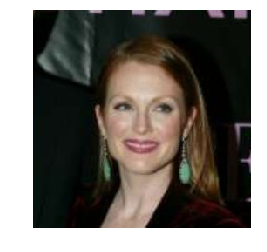

'Hello human, you look like  81.39% Lowchen'

In [103]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path, display=True):
    if display:
        plt.imshow(Image.open(img_path))

        plt.axis('off') 
        plt.show()
    
    if face_detector(img_path) == True:
#         print("Hello human")
        dog_predict_human=predict_breed_transfer(img_path)
        rese_dog = breed_summary(dog_predict_human)
        return "Hello human, you look like "+ rese_dog.split(",")[0]
#         print("you look like", rese_dog)
#         plt.show()
    elif  dog_detector(img_path) == True:
        dog_predict=predict_breed_transfer(img_path)
        dog_breed = breed_summary(dog_predict).split(",")[0]
#         dog = breed_summary(dog_predict_human)
#         print("oops, obviously a dog!")
        return "hey dog, you are: "+dog_breed
#         print(dog_breed)
    else:
#         print("oops, you seem not to be a dog or human being")
        return "oops, you seem not to be a dog or human being"
    ## handle cases for a human face, dog, and neither
test_img = human_files[50]

run_app(test_img)

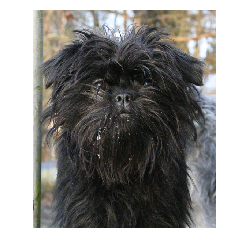

'hey dog, you are:  100.00%  Affenpinscher'

In [82]:
test_dog= dog_files[np.random.randint(8000)]
run_app(test_dog)

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

In [121]:
test_images = np.array(glob("../dog_project/test_images/*"))
def resize_img(image):
    width = int(124)
    height = int(124)
    dim = (width, height)
    '''images contains original dimension image array'''
#     resized_images=[]
#     for i in range(0,images.shape[0]):
    image=cv2.imread(image)
#     image=Image.open(image)

    resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
    return resized


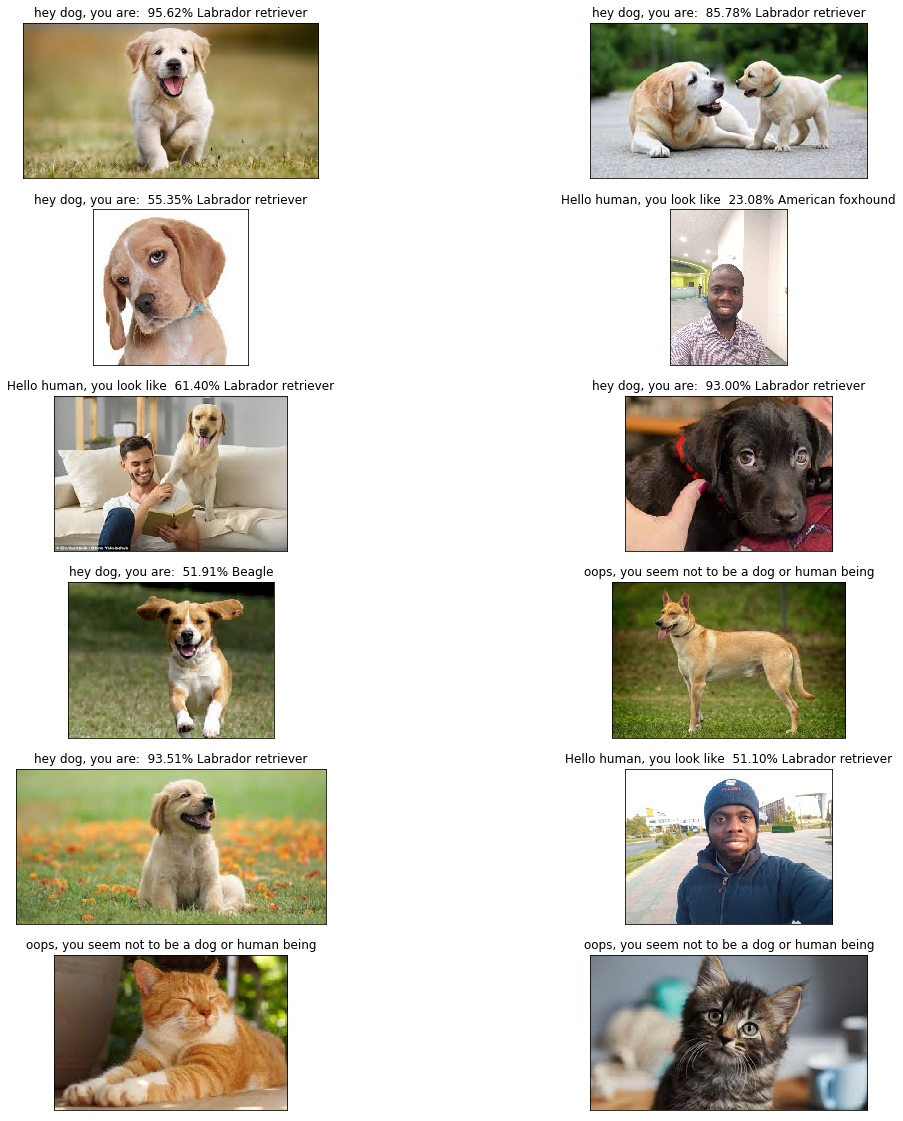

In [130]:
fig = plt.figure(figsize=(20, 20))

gs1 = gridspec.GridSpec(20, 20) 
# gs1.update(wspace=0.00, hspace=0.00) 
for idx in np.arange(len(test_images)):
    ax = plt.subplot(6, 2, idx+1, xticks=[], yticks=[])
#     img = resize_img(test_images[idx])
    text=run_app(test_images[idx],0)
    plt.imshow(Image.open(test_images[idx]))
#     plt.imshow(img)
    ax.set_title(text) 
    ax1.axis('on')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
plt.subplots_adjust(wspace=0.00,)
plt.savefig('result.jpg')



__Answer:__ (Three possible points for improvement)

In [57]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, below
for file in np.hstack((human_files[:3], dog_files[:3])):
    run_app(file)